En este notebook empleamos una estructura de circuito cuántico en la librería Pennylane para la clasificación de diferentes datasets. Entre ellos tenemos Iris y dos generados artificialmente. El primero de ellos es una dataset muy utilizado en ML, el segundo es un dataset que genera dos clases encerradas en círculos y el tercero es una dataset que genera dos clusters linealmente separables. La estructura de este circuito se obtuvo del tutorial en la página de Pennylane (https://pennylane.ai/qml/demos/quantum_neural_net.html) y esta inspirado en el paper de Killoran et al (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063).
El paper lo dividiremos en tres partes, una por cada dataset. El circuito será el mismo pero estará adaptado a cada uno de los datasets a utilizar.

In [0]:
!pip install pennylane pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp

In [0]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, AdagradOptimizer

In [0]:
# vamos a usar el simulador de fotonica
dev = qml.device("default.gaussian", wires=2)#, cutoff_dim = 10)

In [0]:
def layer(v):
  
  qml.Beamsplitter(v[0], v[1], wires = [0, 1])
  # Matrix multiplication of input layer
  qml.Rotation(v[0], wires=0)
  qml.Rotation(v[0], wires=1)
  qml.Squeezing(v[1], 0.0, wires=0)
  qml.Squeezing(v[1], 0.0, wires=1)

  qml.Beamsplitter(v[2], v[3], wires = [0, 1])

  qml.Rotation(v[2], wires=0)
  qml.Rotation(v[2], wires=1)

  # Bias
  qml.Displacement(v[3], 0.0, wires=0)
  qml.Displacement(v[3], 0.0, wires=1)

  # activation
  # qml.Kerr(v[4], wires = 0)
  # qml.Kerr(v[4], wires = 1)

In [0]:
@qml.qnode(dev)
def circuit(var, x_1=None, x_2=None):
  # Encode input x into quantum state
  qml.Displacement(x_1, 0.0, wires=0)
  qml.Displacement(x_2, 0.0, wires=1)

  for v in var:
    # print(v)
    layer(v)


  return qml.expval(qml.X(0))

In [0]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [0]:
# cost function
def cost(var, features, labels):
    preds = [circuit(var, x_1=x_1, x_2=x_2) for (x_1, x_2) in zip(features[:,0], features[:,1])]
    return square_loss(labels, preds)

# funcion que nos da el accuracy
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# **Dataset Iris**

In [0]:
# meto array y quiero que mi circuito aprenda la matriz que multiplicado por X da Y
# cargamos dataset de la plataforma sklearn
from sklearn.datasets import load_iris
from sklearn.preprocessing import Normalizer, StandardScaler

data = load_iris()
datos = data.data
target = data.target

# los escalamos 
# norm = Normalizer()
# norm.fit(datos)
# datos_normalizados = norm.transform(datos)

X = datos[:100, 0:2]

target = target[target < 2]
Y = []
for tar in target:

  if tar == 1:
    Y.append(1)
  else:
    Y.append(0)

Y = np.asarray(Y)

In [0]:
# normalizamos los datos
# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("Primera entrada X (normalized):", X_norm[0])


Primera entrada X (normalized): [0.82451335 0.5658425 ]


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = X_norm[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = X_norm[index[num_train:]]
Y_val = Y[index[num_train:]]

# util para graficar los resultados obtenidos
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [0]:
# var sera la matriz de weights que debera aprender el circuito; la inicializamos con pesos aleatorios
np.random.seed(0)
num_layers = 3
var_init = 0.05 * np.random.randn(num_layers, 4)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466]
 [ 0.0933779  -0.04886389  0.04750442 -0.00756786]
 [-0.00516094  0.02052993  0.00720218  0.07271368]]


In [0]:
Y_train

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1])

In [0]:
# usamos el optimizados Adam
opt_GDO = qml.GradientDescentOptimizer(0.01)
opt_ADAM = AdamOptimizer(0.01)
opt_ADAGRAD = AdagradOptimizer(0.1)

weights = var_init
for it in range(10):
    weights = opt_GDO.step(lambda v: cost(v, feats_train, Y_train), weights)
    # Compute predictions on train and validation set
    predictions_train = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_train]
    predictions_val = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_val]
    # print(predictions_train)
    predictions_train = (abs(np.asarray(predictions_train)) > 0.5)
    predictions_val = (abs(np.asarray(predictions_val)) > 0.5)
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {} | Acc val: {}".format(it + 1, cost(weights, feats_train, Y_train), acc_train, acc_val))


Iter:     1 | Cost: 0.2256639 | Acc train: 0.48 | Acc val: 0.56
Iter:     2 | Cost: 0.1673422 | Acc train: 0.84 | Acc val: 0.76
Iter:     3 | Cost: 0.1594656 | Acc train: 0.9866666666666667 | Acc val: 0.96
Iter:     4 | Cost: 0.1579565 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:     5 | Cost: 0.1575239 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:     6 | Cost: 0.1572932 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:     7 | Cost: 0.1571018 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:     8 | Cost: 0.1569177 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:     9 | Cost: 0.1567348 | Acc train: 0.9866666666666667 | Acc val: 1.0
Iter:    10 | Cost: 0.1565518 | Acc train: 0.9866666666666667 | Acc val: 1.0


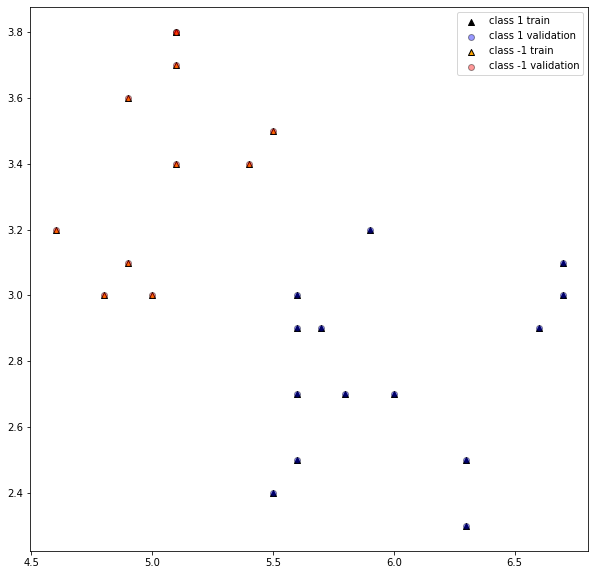

In [0]:
# ploteamos resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val[:, 0][predictions_val == 1],
    X_val[:, 1][predictions_val == 1],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val[:, 0][predictions_val == 0],
    X_val[:, 1][predictions_val == 0],
    c="orange",
    marker="^",
    edgecolors="k",
    label="class 0 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 0],
    X_val[:, 1][Y_val == 0],
    c="r",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 0 validation",
)

plt.legend()
plt.show()

# **Dataset generado artificialmente**


Este dataset lo generamos artificialmente siguiendo el tutorial de pennylane (https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html). Se trata de generar dos clases separadas por un círculo. Es un problema binario y sigue la senda de los datasets tratados hasta ahora.

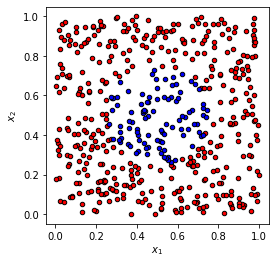

In [0]:
# Make a dataset of points inside and outside of a circle
import matplotlib.pyplot as plt

def circle(samples, center=[0.5, 0.5], radius=0.25):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 1 * (np.random.rand(2)) - 0
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


X_circle, y_circle = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_circle, y_circle, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

In [0]:
# normalizamos los datos
# normalize each input
normalization = np.sqrt(np.sum(X_circle ** 2, -1))
X_circle = (X_circle.T / normalization).T
print("Primera entrada X (normalized):", X_circle[0])


Primera entrada X (normalized): [0.52305957 0.85229613]


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data_circle = len(y_circle)
num_train_circle = int(0.75 * num_data_circle)
index_circle = np.random.permutation(range(num_data_circle))
feats_train_circle = X_circle[index_circle[:num_train_circle]]
Y_train_circle = y_circle[index_circle[:num_train_circle]]
feats_val_circle = X_circle[index_circle[num_train_circle:]]
Y_val_circle = y_circle[index_circle[num_train_circle:]]

# util para graficar los resultados obtenidos
X_train_cirle = X_circle[index_circle[:num_train_circle]]
X_val_circle = X_circle[index_circle[num_train_circle:]]

In [0]:
# var sera la matriz de weights que debera aprender el circuito; la inicializamos con pesos aleatorios
np.random.seed(0)
num_layers = 3
var_init = 0.05 * np.random.randn(num_layers, 4)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466]
 [ 0.0933779  -0.04886389  0.04750442 -0.00756786]
 [-0.00516094  0.02052993  0.00720218  0.07271368]]


In [0]:
# usamos el optimizados Adam
opt_GDO = qml.GradientDescentOptimizer(0.01)
opt_ADAM = AdamOptimizer(0.01)
opt_ADAGRAD = AdagradOptimizer(0.1)

weights = var_init
for it in range(50):
    weights = opt_GDO.step(lambda v: cost(v, feats_train_circle, Y_train_circle), weights)
    # Compute predictions on train and validation set
    predictions_train = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_train_circle]
    predictions_val = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_val_circle]
    # print(predictions_train)
    predictions_train = (abs(np.asarray(predictions_train)) > 0.5)
    predictions_val = (abs(np.asarray(predictions_val)) > 0.5)
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train_circle, predictions_train)
    acc_val = accuracy(Y_val_circle, predictions_val)
    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {} | Acc val: {}".format(it + 1, cost(weights, feats_train_circle, Y_train_circle), acc_train, acc_val))

Iter:     1 | Cost: 0.5956068 | Acc train: 0.4186666666666667 | Acc val: 0.44
Iter:     2 | Cost: 0.4719722 | Acc train: 0.432 | Acc val: 0.384
Iter:     3 | Cost: 0.4327934 | Acc train: 0.4106666666666667 | Acc val: 0.352
Iter:     4 | Cost: 0.4128901 | Acc train: 0.41333333333333333 | Acc val: 0.352
Iter:     5 | Cost: 0.3992519 | Acc train: 0.424 | Acc val: 0.344
Iter:     6 | Cost: 0.3881925 | Acc train: 0.43733333333333335 | Acc val: 0.36
Iter:     7 | Cost: 0.3784398 | Acc train: 0.44 | Acc val: 0.368
Iter:     8 | Cost: 0.3694888 | Acc train: 0.44533333333333336 | Acc val: 0.392
Iter:     9 | Cost: 0.3611124 | Acc train: 0.4533333333333333 | Acc val: 0.4
Iter:    10 | Cost: 0.3531947 | Acc train: 0.464 | Acc val: 0.424
Iter:    11 | Cost: 0.3456677 | Acc train: 0.48 | Acc val: 0.44
Iter:    12 | Cost: 0.3384859 | Acc train: 0.496 | Acc val: 0.464
Iter:    13 | Cost: 0.3316156 | Acc train: 0.5146666666666667 | Acc val: 0.48
Iter:    14 | Cost: 0.3250295 | Acc train: 0.536 | Acc v

In [0]:
# ploteamos resultados
plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val_circle[:, 0][predictions_val == 1],
    X_val_circle[:, 1][predictions_val == 1],
    c="orange",
    marker="^",
    edgecolors="k",
    label="class 1 prediction",
)
plt.scatter(
    X_val_circle[:, 0][Y_val_circle == 1],
    X_val_circle[:, 1][Y_val_circle == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val_circle[:, 0][predictions_val == 0],
    X_val_circle[:, 1][predictions_val == 0],
    c="black",
    marker="o",
    edgecolors="k",
    label="class 0 train",
)
plt.scatter(
    X_val_circle[:, 0][Y_val_circle == 0],
    X_val_circle[:, 1][Y_val_circle == 0],
    c="r",
    marker="^",
    alpha = .4,
    edgecolors="k",
    label="class 0 validation",
)

plt.legend()
plt.show()

# **Dataset Artificial generado con Scikit learn**

In [0]:
from sklearn.datasets import make_blobs
X_blob, y = make_blobs(n_samples=400, centers=2, n_features=2, random_state=42)

In [0]:
y_blob = []
for tar in y:

  if tar == 1:
    y_blob.append(1)
  else:
    y_blob.append(0)

In [0]:
y_blob = np.asarray(y_blob)

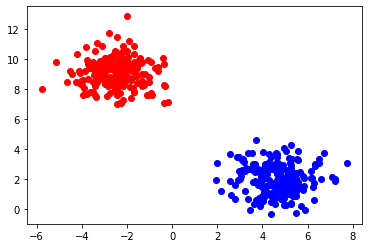

In [0]:
plt.scatter(X_blob[:,0][y_blob == 0],X_blob[:,1][y_blob == 0],c='r')
plt.scatter(X_blob[:,0][y_blob == 1],X_blob[:,1][y_blob == 1], c='b')

In [0]:
# normalizamos los datos
# normalize each input
normalization = np.sqrt(np.sum(X_blob ** 2, -1))
X_blob = (X_blob.T / normalization).T
print("Primera entrada X (normalized):", X_blob[0])

Primera entrada X (normalized): [0.9707569  0.24006467]


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data_blob = len(y_blob)
num_train_blob = int(0.75 * num_data_blob)
index_blob = np.random.permutation(range(num_data_blob))
feats_train_blob = X_blob[index_blob[:num_train_blob]]
Y_train_blob = y_blob[index_blob[:num_train_blob]]
feats_val_blob = X_blob[index_blob[num_train_blob:]]
Y_val_blob = y_blob[index_blob[num_train_blob:]]

# util para graficar los resultados obtenidos
X_train_blob = X_blob[index_blob[:num_train_blob]]
X_val_blob = X_blob[index_blob[num_train_blob:]]

In [0]:
# var sera la matriz de weights que debera aprender el circuito; la inicializamos con pesos aleatorios
np.random.seed(0)
num_layers = 3
var_init = 0.05 * np.random.randn(num_layers, 4)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466]
 [ 0.0933779  -0.04886389  0.04750442 -0.00756786]
 [-0.00516094  0.02052993  0.00720218  0.07271368]]


In [0]:
# usamos el optimizados Adam
opt_GDO = qml.GradientDescentOptimizer(0.01)
opt_ADAM = AdamOptimizer(0.01)
opt_ADAGRAD = AdagradOptimizer(0.1)

weights = var_init
for it in range(20):
    weights = opt_GDO.step(lambda v: cost(v, feats_train_blob, Y_train_blob), weights)
    # Compute predictions on train and validation set
    predictions_train = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_train_blob]
    predictions_val = [circuit(weights, x_1 = f, x_2 = g) for f, g in feats_val_blob]
    print(predictions_train)
    predictions_train = (abs(np.asarray(predictions_train)) > 0.5)
    predictions_val = (abs(np.asarray(predictions_val)) > 0.5)
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train_blob, predictions_train)
    acc_val = accuracy(Y_val_blob, predictions_val)
    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {} | Acc val: {}".format(it + 1, cost(weights, feats_train_blob, Y_train_blob), acc_train, acc_val))

[1.7386528961910752, 1.4592684239261484, 1.9543039212737052, -0.6927958682464382, -0.46116308815078433, 1.679802852454896, -0.6397037631675572, 1.9942406040259957, -0.7170957749524903, -0.7443867076413784, 1.894276163735583, -0.9910363545829977, 1.8507613708383541, -0.5878291740920456, 1.8048687727021606, 1.4062098262109968, -0.5805710862737482, 1.7341581001714925, -0.5463363387459793, -0.4671187975347758, 1.8899116500005295, 1.4873348215741933, -0.41869798298120375, 1.3981668992523888, -0.6690351588413251, 2.022606303250007, -0.817939020599041, -0.5737585726987088, -0.7713501996138468, 1.8225770059374093, 1.9427544427025047, -0.6533239022913326, -0.8478425474755387, 1.9626088463077032, 1.7393975490876805, -0.6667774307534774, 1.8914198627601733, -0.638163367607772, 1.8095301151569114, -0.739808158234175, 1.813827804272267, 1.6752749737254826, 1.4119803822117316, 1.6038819769819324, 1.873861002142356, -0.7335387083588891, 1.9462489865470225, 1.914707668630782, -0.5685173797132705, -0.6

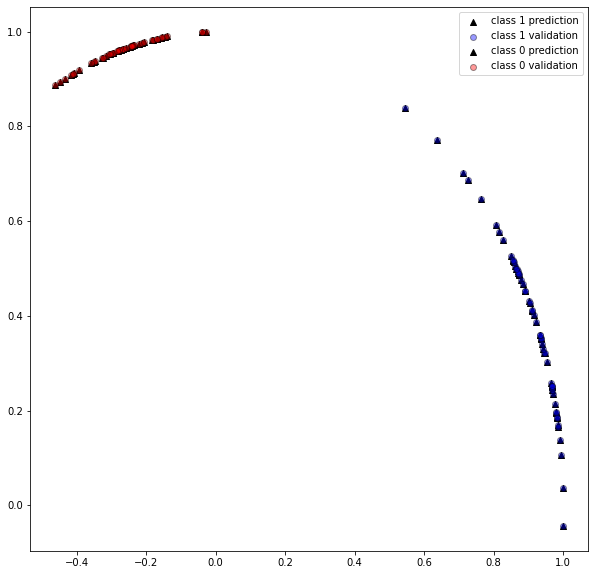

In [0]:
# # ploteamos resultados
plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val_blob[:, 0][predictions_val == 1],
    X_val_blob[:, 1][predictions_val == 1],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 1 prediction",
)
plt.scatter(
    X_val_blob[:, 0][Y_val_blob == 1],
    X_val_blob[:, 1][Y_val_blob == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val_blob[:, 0][predictions_val == 0],
    X_val_blob[:, 1][predictions_val == 0],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 0 prediction",
)
plt.scatter(
    X_val_blob[:, 0][Y_val_blob == 0],
    X_val_blob[:, 1][Y_val_blob == 0],
    c="r",
    marker="o",
    alpha = 0.4,
    edgecolors="k",
    label="class 0 validation",
)

plt.legend()
plt.show()